In [10]:
from pairs_helper_functions import *


/opt/homebrew/Cellar/python@3.9/3.9.12/Frameworks/Python.framework/Versions/3.9/lib/python3.9/sre_parse.py:529: RuntimeWarning: coroutine 'handler' was never awaited
  subpatternappend((LITERAL, _ord(this)))


In [4]:
from oms import OMS
o = OMS()
o.range(side="sell", "APE", [], size, num_orders)

min drawdown: -8.4%
max return: 37.11%
current return: 33.13%
LOOKS : 1
GMT : -1


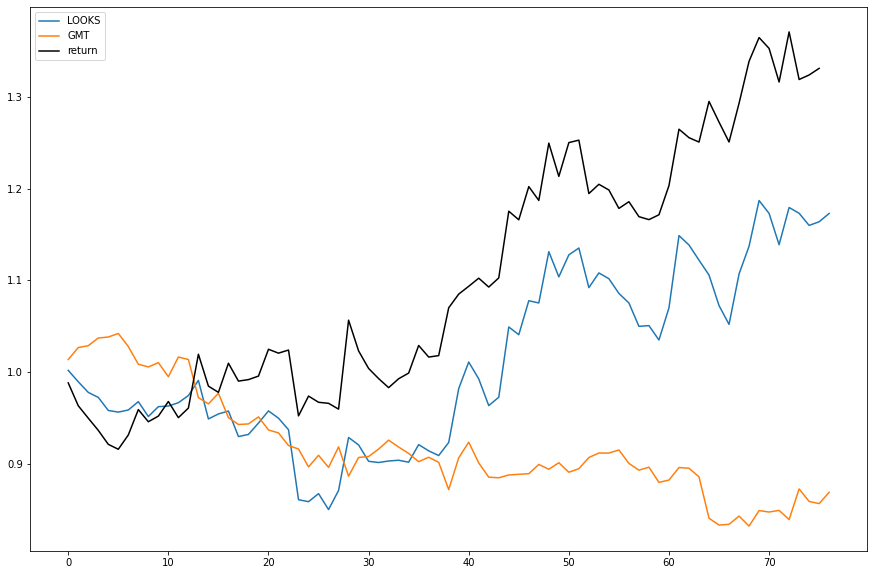

In [16]:
a,b = multi_weighted_index({"LOOKS":1, "GMT":-1}, 2, resolution="1m")


TypeError: analyze() takes 1 positional argument but 3 were given

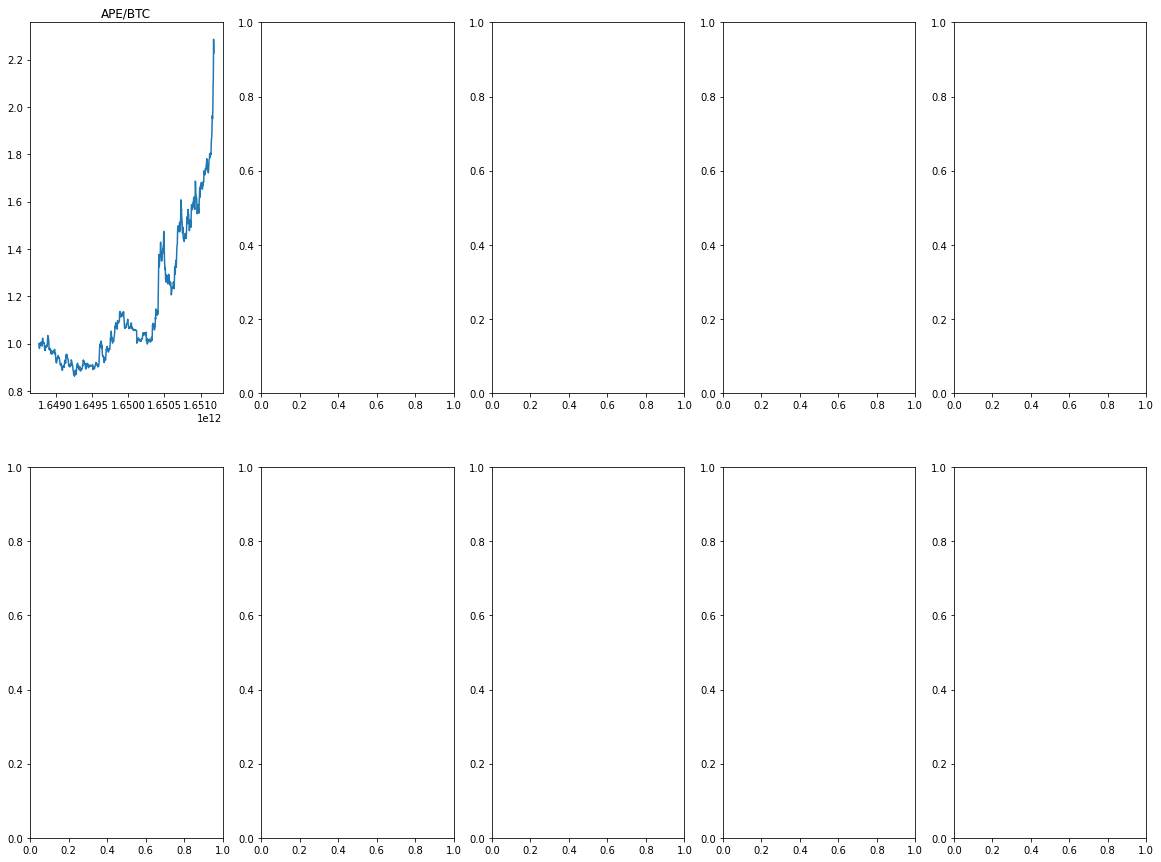

In [7]:
a= compare("2022-04-01", "APE-PERP" , long=True)

In [23]:
import ccxt
import numpy as np
import pandas as pd
import os
from dotenv import load_dotenv
load_dotenv()
pd.options.plotting.backend = "plotly"
ftx =  ccxt.ftx({
                            'apiKey': os.getenv('API_KEY'),
                            'secret': os.getenv('API_SECRET'),
                        })

positions = pd.DataFrame(ftx.fetch_positions())
print(positions.columns)
positions[['symbol','notional',
           'unrealizedPnl','contracts',
           'markPrice', 'percentage', 'liquidationPrice',
           'side',
          ]]

Index(['info', 'symbol', 'timestamp', 'datetime', 'initialMargin',
       'initialMarginPercentage', 'maintenanceMargin',
       'maintenanceMarginPercentage', 'entryPrice', 'notional', 'leverage',
       'unrealizedPnl', 'contracts', 'contractSize', 'marginRatio',
       'liquidationPrice', 'markPrice', 'collateral', 'marginType', 'side',
       'percentage'],
      dtype='object')


,symbol,notional,unrealizedPnl,contracts,markPrice,percentage,liquidationPrice,side
0,UST/USD:USD,NaN,NaN,0.00,NaN,NaN,NaN,long
1,MINA/USD:USD,NaN,NaN,0.00,NaN,NaN,NaN,long
2,GMT/USD:USD,NaN,NaN,0.00,NaN,NaN,NaN,long
3,LOOKS/USD:USD,NaN,NaN,0.00,NaN,NaN,NaN,long
4,FTT/USD:USD,NaN,NaN,0.00,NaN,NaN,NaN,long
5,FIDA/USD:USD,NaN,NaN,0.00,NaN,NaN,NaN,long
6,AR/USD:USD,NaN,NaN,0.00,NaN,NaN,NaN,long
7,ICP/USD:USD,NaN,NaN,0.00,NaN,NaN,NaN,long
8,BTC/USD:USD,NaN,NaN,0.00,NaN,NaN,NaN,long
9,EOS/USD:USD,NaN,NaN,0.00,NaN,NaN,NaN,long


In [36]:
import pandas as pd
df = pd.read_csv("../data/Binance_ETHUSDT_1h.csv")

In [41]:
import pandas_ta as ta

In [45]:
post_2020 = df[df['date'] > "2020-01-01"]
post_2020.ta.hma(length=200)

0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
            ...    
20451    127.890402
20452    127.896096
20453    127.903092
20454    127.911104
20455    127.913539
Name: HMA_200, Length: 20456, dtype: float64

In [48]:
post_2020

,unix,date,symbol,open,high,low,close,Volume ETH,Volume USDT,tradecount
0,1.651536e+12,2022-05-03 00:00:00,ETH/USDT,2856.54,2861.47,2844.96,2847.31,10532.6185,3.006147e+07,12047.0
1,1.651532e+12,2022-05-02 23:00:00,ETH/USDT,2861.91,2874.48,2851.20,2856.54,12542.0559,3.593712e+07,15951.0
2,1.651529e+12,2022-05-02 22:00:00,ETH/USDT,2866.14,2894.22,2860.94,2861.91,18304.8920,5.256567e+07,25732.0
3,1.651525e+12,2022-05-02 21:00:00,ETH/USDT,2827.00,2869.39,2824.08,2866.14,18958.5606,5.411102e+07,32537.0
4,1.651522e+12,2022-05-02 20:00:00,ETH/USDT,2841.72,2847.64,2825.99,2826.99,15735.8704,4.466289e+07,17266.0
...,...,...,...,...,...,...,...,...,...,...
20451,1.577851e+09,2020-01-01 04-AM,ETH/USDT,130.20,130.74,130.15,130.20,3347.0900,4.363809e+05,NaN
20452,1.577848e+09,2020-01-01 03-AM,ETH/USDT,130.85,130.89,129.94,130.20,4691.4500,6.112795e+05,NaN
20453,1.577844e+09,2020-01-01 02-AM,ETH/USDT,130.64,130.98,130.35,130.85,7500.5700,9.805787e+05,NaN
20454,1.577840e+09,2020-01-01 01-AM,ETH/USDT,128.87,130.65,128.78,130.64,11128.4800,1.446168e+06,NaN


In [44]:
help(ta.ma)

Help on function ma in module pandas_ta.overlap.ma:

ma(name: str = None, source: pandas.core.series.Series = None, **kwargs) -> pandas.core.series.Series
    Simple MA Utility for easier MA selection
    
    Available MAs:
        dema, ema, fwma, hma, linreg, midpoint, pwma, rma,
        sinwma, sma, swma, t3, tema, trima, vidya, wma, zlma
    
    Examples:
        ema8 = ta.ma("ema", df.close, length=8)
        sma50 = ta.ma("sma", df.close, length=50)
        pwma10 = ta.ma("pwma", df.close, length=10, asc=False)
    
    Args:
        name (str): One of the Available MAs. Default: "ema"
        source (pd.Series): The 'source' Series.
    
    Kwargs:
        Any additional kwargs the MA may require.
    
    Returns:
        pd.Series: New feature generated.

